In [ ]:
from qiskit import *
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
v=np.arange(0,8,1)
e=[(0,1,1),(1,3,4),(1,3,1),(0,5,2),(2,4,7),(3,4,6),(4,5,3),(4,6,4),(2,6,3),(3,6,1),(4,7,5),(6,7,1),(1,7,2)]

In [ ]:
g=nx.Graph()
g.add_nodes_from(v)
g.add_weighted_edges_from(e)
nx.draw_networkx(g)

In [13]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import time

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# Generating a graph of 4 nodes

n = 15  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 2, 1.0), (0, 3, 1.0), (0, 4, 1.0), (0, 5, 1.0), (0, 9, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0), 
        (2, 3, 1.0), (2, 4, 1.0), (2, 6, 1.0), (2, 7, 1.0), (4, 5, 1.0), (4, 6, 1.0), (5, 8, 1.0), (5, 9, 1.0), 
        (6, 7, 1.0), (6, 8, 1.0), (6, 9, 1.0), (7, 8, 1.0), (7, 10, 1.0), (7, 14, 1.0), (8, 12, 1.0), (8, 13, 1.0), 
        (8, 14, 1.0), (9, 10, 1.0), (9, 11, 1.0), (9, 13, 1.0), (10, 12, 1.0), (10, 13, 1.0), (10, 14, 1.0), (11, 13, 1.0), 
        (12, 13, 1.0), (12, 14, 1.0), (13, 14, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

[[0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0.]]
Problem name: Max-cut

Maximize
  -2*x_0*x_2 - 2*x_0*x_3 - 2*x_0*x_4 - 2*x_0*x_5 - 2*x_0*x_9 - 2*x_1*x_3
  - 2*x_1*x_4 - 2*x_1*x_5 - 2*x_10*x_12 - 2*x_10*x_13 - 2*x_10*x_14
  - 2*x_11*x_13 - 2*x_12*x_13 - 2*x_12*x_14 - 2*x_13*x_14 - 2*x_2*x_3
  - 2*x_2*x_4 - 2*x_2*x_6 - 2*x_2*x_

In [14]:
algorithm_globals.random_seed = 123
seed = 10598

# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

KeyboardInterrupt: 

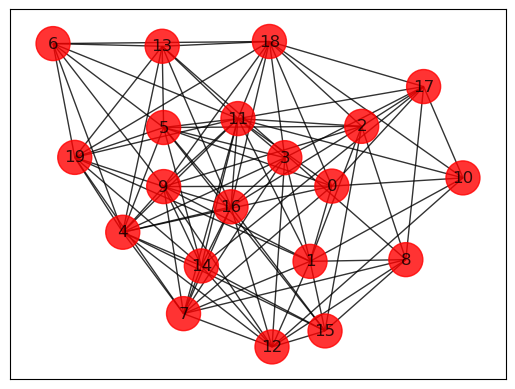

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

n = 20  # Number of nodes in graph
p = 0.5  # Probability of edge creation
G = nx.gnp_random_graph(n, p)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, pos=pos)
plt.show()

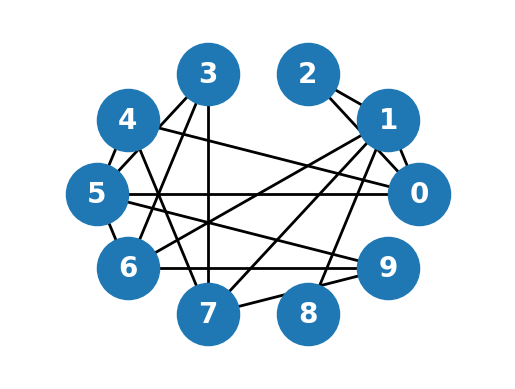

In [9]:
# 随机生成10个节点的图
import networkx as nx   #导入networkx包
import random #导入random包
import matplotlib.pyplot as plt #导入画图工具包
 
G = nx.Graph()			#建立无向图
H = nx.path_graph(10)	#添加节点，10个点的无向图
G.add_nodes_from(H)		#添加节点
 
 
def rand_edge(vi,vj,p=0.6):		#默认概率p=0.1
    probability =random.random()#生成随机小数
    if(probability>p):			#如果大于p
        G.add_edge(vi,vj)  		#连接vi和vj节点
 
i=0
while (i<10):
    j=0
    while(j<i):
            rand_edge(i,j)		#调用rand_edge()
            j +=1
    i +=1
 
# 将生成的图 G 打印出来
pos = nx.circular_layout(G)
options = {
    "with_labels": True,
    "font_size": 20,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 2000,
    "width": 2
}
nx.draw_networkx(G, pos, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [11]:
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.optimization.applications.ising import graph_partition
from qiskit.optimization.applications.ising.common import random_graph, sample_most_likely

num_nodes = 4
w = random_graph(num_nodes, edge_prob=0.8, weight_range=10, seed=48)
print(w)

G = nx.from_numpy_matrix(w)
layout = nx.random_layout(G, seed=10)
colors = ['r', 'g', 'b', 'y']
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

ModuleNotFoundError: No module named 'qiskit.optimization'